# Import các thư viện cần để sử dụng 

In [1]:
import json
import re
import pandas as pd
import numpy as np
import scrapy
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import warnings
warnings.simplefilter('ignore')

# Convert data from json to csv

In [2]:
json_file_path = "../data/cars_info.json" 

data = pd.read_json(json_file_path) 
df=pd.DataFrame(data)
df=df.set_index("ID")
df.head(5)

,Name,Price,Brand,Model,Variant,Series,Year,Kilometers,Type,Gearbox,Fuel,Status,CC,Color,Seating Capacity
ID,,,,,,,,,,,,,,,
12830792,2004 Nissan Pulsar ST-L N16 MY04,"$7,995",Nissan,Pulsar,ST-L,N16 MY04,2004,"120,083 km",Sedan,Automatic,Unleaded Petrol,Used,1769,Red,5
12825831,2022 BMW X3 M Competition M Steptronic M xDrive,"$178,900",BMW,X3 M,Competition M Steptronic M xDrive,,2022,"3,532 km",Wagon,Automatic,-,Demo,,,
12825829,2022 BMW 3 Series 25i,"$109,900",BMW,3 Series,25i,,2022,"3,544 km",OtherCar,Automatic,-,Demo,,White,
12825828,2022 BMW 3 Series 25i,"$110,900",BMW,3 Series,25i,,2022,"3,538 km",OtherCar,Automatic,-,Demo,,Blue,
12700658,2004 Mercedes-Benz Sprinter 316CDI SWB,"$54,890",Mercedes-Benz,Sprinter,316CDI SWB,,2004,"39,915 km",Van,Manual,Diesel,Used,2686,Green,3


In [3]:
shape=df.shape
print("Dữ liệu ban đầu có",shape[0],"dòng và",shape[1],"cột")

Dữ liệu ban đầu có 21291 dòng và 15 cột


Kiểm tra xem có bao nhiêu index giống nhau và xóa những dòng đó đi giữ lại cái xuất hiện đầu tiên

In [4]:
# Kiểm tra xem có dòng 
num_duplicated_rows=np.sum(df.index.duplicated(keep='first'))
print("Có",num_duplicated_rows,"dòng giống nhau bỏ qua dòng đầu tiên")

Có 207 dòng giống nhau bỏ qua dòng đầu tiên


In [5]:
# Xóa các dòng có index giống nhau.
df=(df.reset_index().drop_duplicates(subset='ID', keep='first').set_index('ID').sort_index())

# Ý nghĩa từng trường thông tin
Mỗi dòng có ý nghĩa gì? Có vấn đề các dòng có ý nghĩa khác nhau không?

==> Mỗi dòng đại diện cho một chiếc xe được bán. Không có vấn đề mỗi dòng có ý nghĩa khác nhau. Các dòng đều mang một ý nghĩa như nhau là thể hiện chiếc xe đang được bán.

Mỗi cột có ý nghĩa gì?

==>Mỗi cột là một thông số của xe. Ở đây tụi em sử dụng 16 cột dữ liệu, ý nghĩa của mỗi cột như sau:

- ID: Mã số của xe.
- Name: Tên xe.
- Price: Giá xe.
- Brand: Thương hiệu xe.
- Model: Đời xe.
- Variant: Biến thể xe.
- Series: Series xe.
- Year: Năm sản xuất.
- Kilometers: Số km xe chạy được (xe mới thuộc tính này là 0).
- Type: Loại xe (Sedan, Wagon, Coupe,...).
- Gearbox: Hộp số (Tự động, thủ công,...).
- Fuel: Nhiên liệu (Dầu, xăng,...).
- Status: Trạng thái (Đã sử dụng, thử nghiệm,...).
- CC: Phân khối.
- Color: Màu xe.
- Seating Capacity: Số chỗ ngồi.

# Kiểm tra kiểu dữ liệu của từng cột


In [6]:
df.dtypes

Name                object
Price               object
Brand               object
Model               object
Variant             object
Series              object
Year                 int64
Kilometers          object
Type                object
Gearbox             object
Fuel                object
Status              object
CC                  object
Color               object
Seating Capacity    object
dtype: object

In [7]:
max_year=df["Year"].max()
min_year=df["Year"].min()
print("Pham vi cột Year là từ năm",min_year,"đến năm",max_year)

Pham vi cột Year là từ năm 1976 đến năm 2022


- Mỗi cột hiện đang có kiểu dữ liệu gì? Khoảng biểu diễn của kiểu dữ liệu đó ra sao? Có cột nào có kiểu dữ liệu chưa phù hợp để có thể xử lý tiếp hay không?

==> Kiểu dữ liệu của cột: 
- ID: int.
- Name: string.
- Price: string.
- Brand: string.
- Model: string.
- Variant: string.
- Series: string.
- Year: int.
- Kilometers: string.
- Type: string.
- Gearbox: string.
- Fuel: string.
- Status: string.
- CC: string.
- Color: string.
- Seating Capacity: string
Khoảng biểu diễn của kiểu dữ liệu đó ra sao?

==>Đa số đều là string nên có phạm vi biểu diễn cụ thể.

==>ID là đại diện cho mỗi chiếc xe nên không có phạm vi cụ thể

==>Pham vi cột Year là từ năm 1976 đến năm 2022

Có cột nào có kiểu dữ liệu chưa phù hợp để có thể xử lý tiếp hay không?

==> Có một số cột ta có thể chuyển từ string về dạng số, có thể là float để dễ dàng xử lý. Các cột đó là cột "Price", "Kilometers", "CC", "Seating Capacity".

# Tiền Xử Lý Dữ Liệu

In [8]:
cols=["Price", "Kilometers", "CC", "Seating Capacity"]

df['Price'] = df['Price'].str.replace('$','')
df['Price'] = df['Price'].str.replace(',','')

df['Kilometers'] = df['Kilometers'].str.replace(' km','')
df['Kilometers'] = df['Kilometers'].str.replace(',','')

Xóa các dòng có cột bị trống

In [9]:
for col in df.columns:
    df.drop(df.index[df[col] == '-'], inplace = True)
    df.drop(df.index[df[col] == ''], inplace = True)

Chuyển các cột sai kiểu dữ liệu thành kiểu dữ liệu hợp lệ và kiểm tra xe còn bao nhiêu cột

In [10]:
df = df.astype({'Price':'int64','Kilometers':'int64','CC':'int64','Seating Capacity':'int64'})

Kiểm tra các cột số (Price, Year, CC, Seating Capacity) có giá trị nhỏ hơn hoặc bằng 0 trừ Kilometers vì xe mới có thể chưa chạy.

In [11]:
num_invalid_Price_vals=0
for index, row in df.iterrows():
    if row['Price']<=0:
        num_invalid_Price_vals+=1
print("Số dòng có giá nhỏ hơn hoặc bằng 0:",num_invalid_Price_vals)

Số dòng có giá nhỏ hơn hoặc bằng 0: 0


In [12]:
num_invalid_Year_vals=0
for index, row in df.iterrows():
    if row['Year']<=0:
        num_invalid_Price_vals+=1
print("Số dòng có năm sản xuất nhỏ hơn hoặc bằng 0:",num_invalid_Year_vals)

Số dòng có năm sản xuất nhỏ hơn hoặc bằng 0: 0


In [13]:
num_invalid_CC_vals=0
for index, row in df.iterrows():
    if row['CC']<=0:
        num_invalid_CC_vals+=1
print("Số dòng có phân khối nhỏ hơn hoặc bằng 0:",num_invalid_CC_vals)

# Xóa các dòng không phù hợp
for index, row in df.iterrows():
    if row['CC']<=0:
        df.drop(index,inplace=True)

Số dòng có phân khối nhỏ hơn hoặc bằng 0: 48


In [14]:
num_invalid_Seating_vals=0
for index, row in df.iterrows():
    if row['Seating Capacity']<=0:
        num_invalid_Seating_vals+=1
print("Số dòng có số chỗ ngồi nhỏ hơn hoặc bằng 0:",num_invalid_Seating_vals)


Số dòng có số chỗ ngồi nhỏ hơn hoặc bằng 0: 0


In [15]:
shape=df.shape
print("Dữ liệu sau khi xóa có",shape[0],"dòng và",shape[1],"cột")

Dữ liệu sau khi xóa có 17048 dòng và 15 cột


In [16]:
csv_file_path = "../data/cars_info_preprocessed.csv"
df.to_csv(csv_file_path)

#  Tìm hiểu dữ liệu:

Đối với giá cả, số km đã đi, và CC của xe ta sử dụng thống kê mô tả để có cái nhìn tổng quát

In [17]:
print(df['Price'].describe().round(3))
print(df['Kilometers'].describe().round(3))
print(df['CC'].describe().round(3))

count     17048.000
mean      36777.778
std       30305.015
min        1000.000
25%       18800.000
50%       29990.000
75%       45990.000
max      999000.000
Name: Price, dtype: float64
count      17048.000
mean      103231.402
std        80413.131
min            1.000
25%        44502.250
50%        88454.000
75%       148873.500
max      2700000.000
Name: Kilometers, dtype: float64
count    17048.000
mean      2491.830
std        881.986
min        875.000
25%       1987.000
50%       2354.000
75%       2981.000
max       7300.000
Name: CC, dtype: float64


Đối với các dữ liệu khác ta dùng biểu đồ để có cái nhìn tổng quát


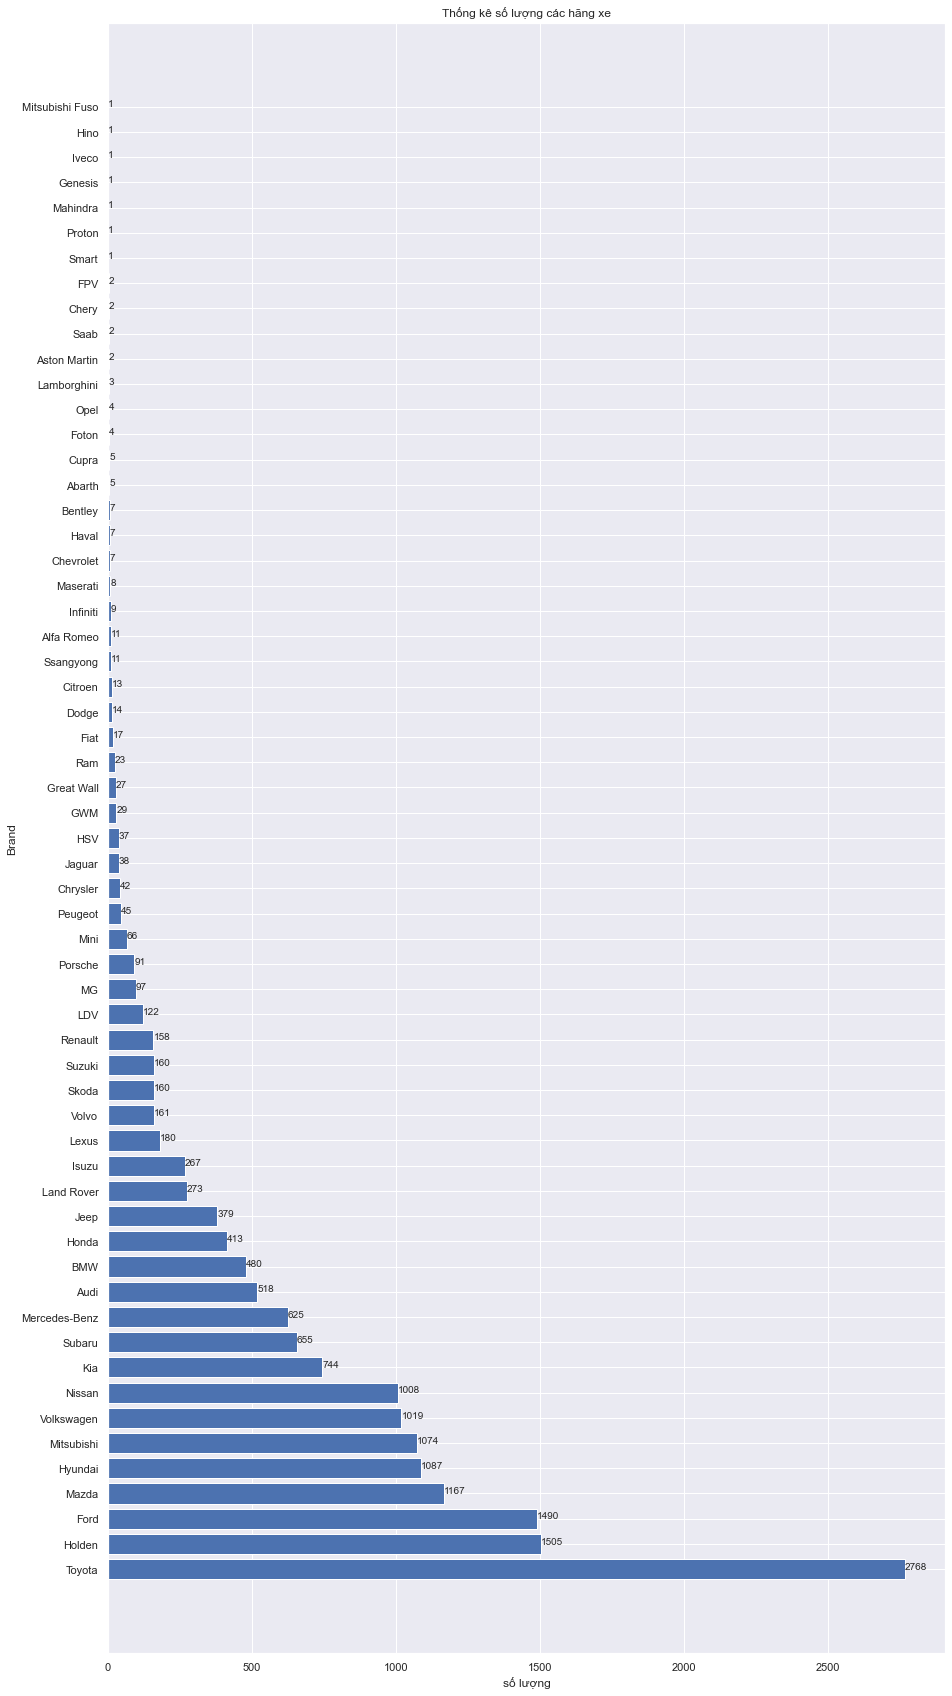

In [18]:
infor = np.array(df['Brand'].value_counts().index)
count = np.array(df['Brand'].value_counts())
fig,ax=plt.subplots()
fig.set_figheight(30)
fig.set_figwidth(15)
for i, v in enumerate(count):
    ax.text(v , i, str(v))
plt.barh(infor,count)
plt.xlabel('số lượng')
plt.ylabel('Brand')  
plt.title('Thống kê số lượng các hãng xe')
plt.show()

=> Có thể thấy các hãng xe phổ biến trên thị trường hiện nay chiếm số lượng nhiều nhất. Đặc biệt là Toyota sau đó là Forf và Holden

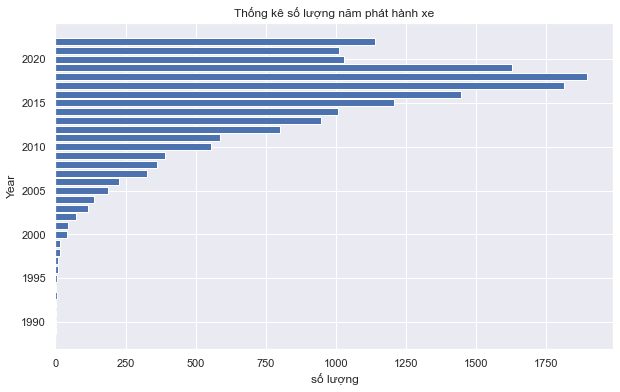

In [19]:
infor = np.array(df['Year'].value_counts().index)
count = np.array(df['Year'].value_counts())

plt.figure(figsize = (10,6))
plt.barh(infor,count)
plt.xlabel('số lượng')
plt.ylabel('Year')  
plt.title('Thống kê số lượng năm phát hành xe')
plt.show()

=> Phần lớn các xe đều được sản xuất trong vòng 10 năm gần nhất từ 2010 -2020

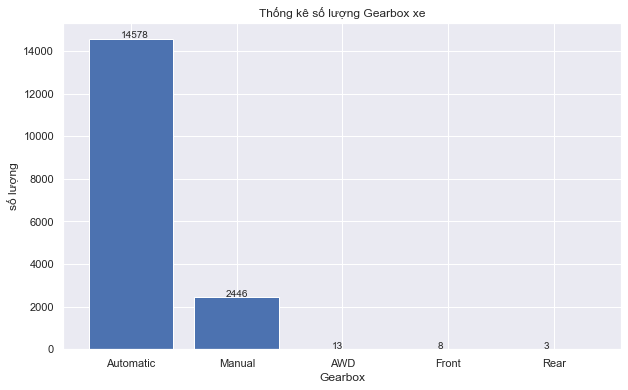

In [20]:
infor = np.array(df['Gearbox'].value_counts().index)
count = np.array(df['Gearbox'].value_counts())
plt.figure(figsize = (10,6))
for i in range(len(infor)):
        plt.annotate(count[i], (-0.1+i, count[i]+20))
plt.bar(infor,count)
plt.xlabel('Gearbox')
plt.ylabel('số lượng')  
plt.title('Thống kê số lượng Gearbox xe')
plt.show()

=> Phần lớn xe là hộp số tự động 

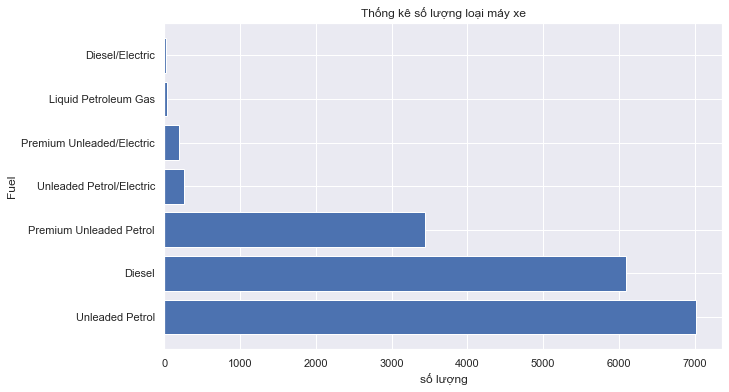

In [21]:
infor = np.array(df['Fuel'].value_counts().index)
count = np.array(df['Fuel'].value_counts())

plt.figure(figsize = (10,6))

plt.barh(infor,count)
plt.xlabel('số lượng')
plt.ylabel('Fuel')  
plt.title('Thống kê số lượng loại máy xe')
plt.show()

=> Phần lớn là xe dầu và xe xăng

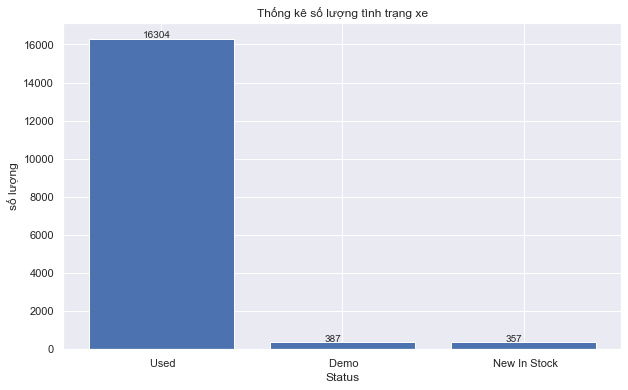

In [22]:
infor = np.array(df['Status'].value_counts().index)
count = np.array(df['Status'].value_counts())
plt.figure(figsize = (10,6))
for i in range(len(infor)):
        plt.annotate(count[i], (-0.1+i, count[i]+20))
plt.bar(infor,count)
plt.xlabel('Status')
plt.ylabel('số lượng')  
plt.title('Thống kê số lượng tình trạng xe')
plt.show()

=> Phần lớn là xe đã qua sử dụng (used) phần còn lại rất ít là xe mới và xe ít dùng 

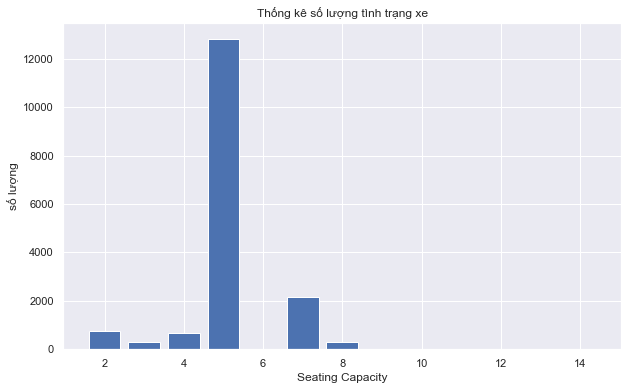

In [23]:
infor = np.array(df['Seating Capacity'].value_counts().index)
count = np.array(df['Seating Capacity'].value_counts())
plt.figure(figsize = (10,6))

plt.bar(infor,count)
plt.xlabel('Seating Capacity')
plt.ylabel('số lượng')  
plt.title('Thống kê số lượng tình trạng xe')
plt.show()

=> Phần lớn là xe 5 chỗ 